In [2]:
# Code for hiding seaborn warnings
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
#import altair as alt
# need to 'pip install vega' before using renderer
#alt.renderers.enable("notebook")
# Code for hiding seaborn warnings
import warnings
warnings.filterwarnings("ignore")
from imblearn.over_sampling import SMOTE
from sklearn import preprocessing,metrics
from sklearn.metrics import accuracy_score,f1_score,recall_score,roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve,StratifiedKFold, cross_val_score
from sklearn import svm
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.decomposition import PCA,TruncatedSVD
import scipy
import os
from joblib import dump, load
from sklearn.metrics import classification_report,confusion_matrix,plot_confusion_matrix
from sklearn.metrics import precision_recall_fscore_support as prfs
# test for Selecting The Best Number Of Components For TSVD
from sklearn.preprocessing import StandardScaler
from scipy.sparse import csr_matrix
#from varname import varname
%matplotlib inline
#fix random seed
np.random.seed(1)

In [29]:
def get_model_nosmote(df_train):
    # get train_x and train_y
    new_df = df_train
    new_df = new_df.dropna()
    train_x = new_df.key_word.apply(lambda x: x.replace('_', ''))
    train_y = new_df.topic
    le = preprocessing.LabelEncoder()
    le.fit(train_y)
    encode_mapping = dict(zip(le.classes_, range(len(le.classes_))))
    en_train_y = le.transform(train_y)
    topics = list(set(new_df['topic']))
    # Using SMOTE to solve imbalance
    #smote = SMOTE(random_state=1)
    #vectorizer = TfidfVectorizer()
    #vectorizer.fit(train_x)
    #train_vectors = vectorizer.transform(train_x)
    #smo_x,smo_y = smote.fit_sample(train_vectors,en_train_y)
    #new_train_x = vectorizer.inverse_transform(smo_x)
    #new_train_x = pd.Series([','.join(item) for item in new_train_x])
    
    tf_df = TfidfVectorizer().fit_transform(train_x)
    
    wc_df = CountVectorizer().fit_transform(train_x)
    
    svm_model = svm.SVC(gamma=0.001, C=10.,decision_function_shape = 'ovo', class_weight = 'balanced')
    
    accs_tf = np.mean(cross_val_score(svm_model, 
                           tf_df, en_train_y, cv=5))
    
    accs_wc = np.mean(cross_val_score(svm_model, 
                           wc_df, en_train_y, cv=5))
    
    if(accs_tf>=accs_wc):
        print(f'*************************************************************')
        print(f'Now the training set is {df_train.name}, and the model chosen is tf')
        print(f'The accuracy is {accs_tf}')
        final_model = svm_model.fit(tf_df,en_train_y )
        my_vect = TfidfVectorizer().fit(train_x)
        return (final_model ,le,encode_mapping, my_vect)
    else:
        print(f'*************************************************************')
        print(f'Now the training set is {df_train.name}, and the model chosen is wc')
        print(f'The accuracy is {accs_wc}')
        final_model = svm_model.fit(wc_df,en_train_y )
        my_vect = CountVectorizer().fit(train_x)
        return (final_model,le,encode_mapping, my_vect)        



def test_model(df_test,model,le,encode_mapping, my_vect):
    test_x = df_test.key_word
    test_y = df_test.topic
    topics = list(set(df_test['topic']))
    en_test_y = le.transform(test_y)
    y_pred = model.predict(my_vect.transform(test_x))
    get_scores(en_test_y,y_pred,type(model).__name__)
    print(encode_mapping)
    print(f"Classification Report:\n{classification_report(en_test_y, y_pred)}")
    print("The scores for each topic is:")
    scores_for_topics(df_test,topics,model,le, my_vect)
    conf_matrix = confusion_matrix(en_test_y, y_pred)
    print(conf_matrix)
    fig1 = plt.figure(figsize=(13,6))
    sns.heatmap(conf_matrix,
    #             square=True,
                annot=True, # show numbers in each cell
                fmt='d', # set number format to integer in each cell
                yticklabels=le.classes_,
                xticklabels=model.classes_,
                cmap="Blues",
    #             linecolor="k",
                linewidths=.1,
               )
    plt.title(
              f"Confusion Matrix on Test Set | ", 
              fontsize=14)
    plt.xlabel("Actual: False positives for y != x", fontsize=12)
    plt.ylabel("Prediction: False negatives for x != y", fontsize=12)
    plt.show()
    
def scores_for_topics(df,topics,model,le, my_vect):
    scores = []
    for topic in topics:
        topic_scores(df,topic,model,le,scores, my_vect)
    scores.sort(reverse=True,key=lambda x:x[1]['accuracy'])
    for item in scores:
        print(item)

def topic_scores(df,topic,model,le,scores, my_vect):
    filtered_df = df[df.topic==topic]
    test_x = filtered_df.key_word.apply(lambda x: x.replace('_', ''))
    test_y = filtered_df.topic
    #le.fit(train_y)
    en_test_y = le.transform(test_y)
    prediction = model.predict(my_vect.transform(test_x))
    scores.append(get_scores(en_test_y,prediction,type(model).__name__,topic))

def get_scores(en_train_y,pred_y,model_name,topic=None):
    f1 = f1_score(en_train_y,pred_y,average='macro')
    accuracy = accuracy_score(en_train_y,pred_y)
    recall = recall_score(en_train_y,pred_y,average='macro')
    if(topic==None):
        print("F1 score for ",model_name," model is ",f1)
        print("Accuracy score for ",model_name," model is ",accuracy)
        print("Recall score for ",model_name," model is ",recall,"\n")
    else:
        return ([topic,{'accuracy':accuracy,'f1':f1,'recall':recall}])
    


In [18]:
TRAINING_FILE ="../keyword.csv"
TEST_FILE = "../key_word_test.csv"
df_my_train = pd.read_csv(TRAINING_FILE)
df_my_test = pd.read_csv(TEST_FILE)
print(df_my_train.isnull().sum())
df_my_train.head(5)
new_dataset = df_my_train.replace(np.nan, '', regex=True)

Unnamed: 0         0
article_number     0
article_words      0
topic              0
IR_binary          0
key_word_10       62
key_word_20       18
key_word_50        0
key_word_100       0
dtype: int64


In [19]:
df_train_10 = pd.DataFrame(df_my_train,columns=['key_word_10','topic']).rename(columns={'key_word_10':'key_word'})
df_train_10.name = 'df_train_10'
df_train_20 = pd.DataFrame(df_my_train,columns=['key_word_20','topic']).rename(columns={'key_word_20':'key_word'})
df_train_20.name = 'df_train_20'
df_train_50 = pd.DataFrame(df_my_train,columns=['key_word_50','topic']).rename(columns={'key_word_50':'key_word'})
df_train_50.name = 'df_train_50'
df_train_100 = pd.DataFrame(df_my_train,columns=['key_word_100','topic']).rename(columns={'key_word_100':'key_word'})
df_train_100.name = 'df_train_100'
df_train_full = pd.DataFrame(df_my_train,columns=['article_words','topic']).rename(columns={'article_words':'key_word'})
df_train_full.name = 'df_train_full'
df_train_all = [df_train_10,df_train_20,df_train_50,df_train_100]

In [20]:
df_test_10 = pd.DataFrame(df_my_test,columns=['key_word_10','topic']).rename(columns={'key_word_10':'key_word'})
df_test_10.name = 'df_test_10'
df_test_20 = pd.DataFrame(df_my_test,columns=['key_word_20','topic']).rename(columns={'key_word_20':'key_word'})
df_test_20.name = 'df_test_20'
df_test_50 = pd.DataFrame(df_my_test,columns=['key_word_50','topic']).rename(columns={'key_word_50':'key_word'})
df_test_50.name = 'df_test_50'
df_test_100 = pd.DataFrame(df_my_test,columns=['key_word_100','topic']).rename(columns={'key_word_100':'key_word'})
df_test_100.name = 'df_test_100'
df_test_full = pd.DataFrame(df_my_test,columns=['article_words','topic']).rename(columns={'article_words':'key_word'})
df_test_full.name = 'df_test_full'
df_test_all = [df_test_10,df_test_20,df_test_50,df_test_100,df_test_full]

*************************************************************
Now the training set is df_train_10, and the model chosen is wc
The accuracy is 0.6144319294369145
----------------------------------------------------------------------
Now, the train_df is df_train_10, the test_df is df_test_20
F1 score for  SVC  model is  0.40393690304232455
Accuracy score for  SVC  model is  0.582
Recall score for  SVC  model is  0.5250436634303911 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.06      0.33      0.10         3
           1       0.19      0.33      0.24        15
           2       0.41      0.69      0.51        13
           3       0.08      0.50      0.14         2
           4       0.51   

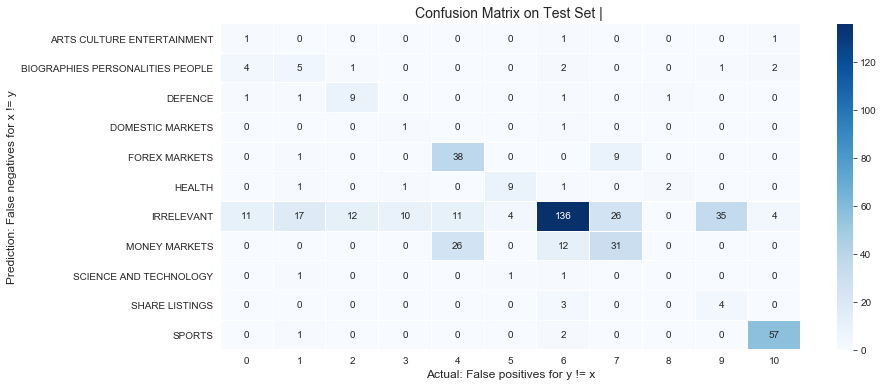

----------------------------------------------------------------------
Now, the train_df is df_train_10, the test_df is df_test_50
F1 score for  SVC  model is  0.40393690304232455
Accuracy score for  SVC  model is  0.582
Recall score for  SVC  model is  0.5250436634303911 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.06      0.33      0.10         3
           1       0.19      0.33      0.24        15
           2       0.41      0.69      0.51        13
           3       0.08      0.50      0.14         2
           4       0.51      0.79      0.62        48
           5       0.64      0.64      0.64        14
           6       0.85      0.51      0.64       266
           7       0.47  

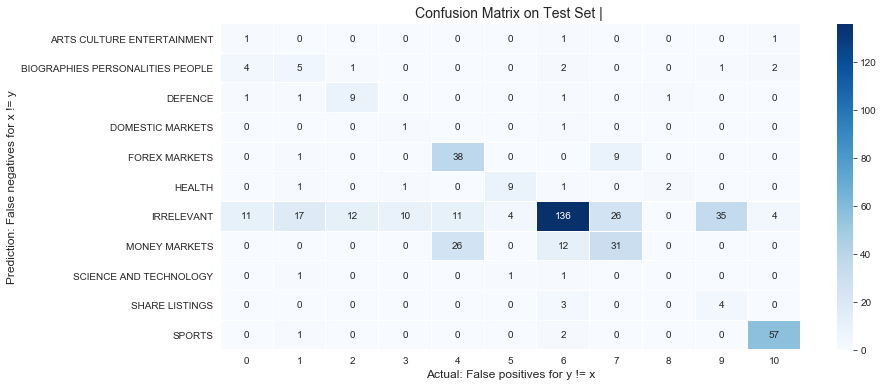

----------------------------------------------------------------------
Now, the train_df is df_train_10, the test_df is df_test_100
F1 score for  SVC  model is  0.40393690304232455
Accuracy score for  SVC  model is  0.582
Recall score for  SVC  model is  0.5250436634303911 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.06      0.33      0.10         3
           1       0.19      0.33      0.24        15
           2       0.41      0.69      0.51        13
           3       0.08      0.50      0.14         2
           4       0.51      0.79      0.62        48
           5       0.64      0.64      0.64        14
           6       0.85      0.51      0.64       266
           7       0.47 

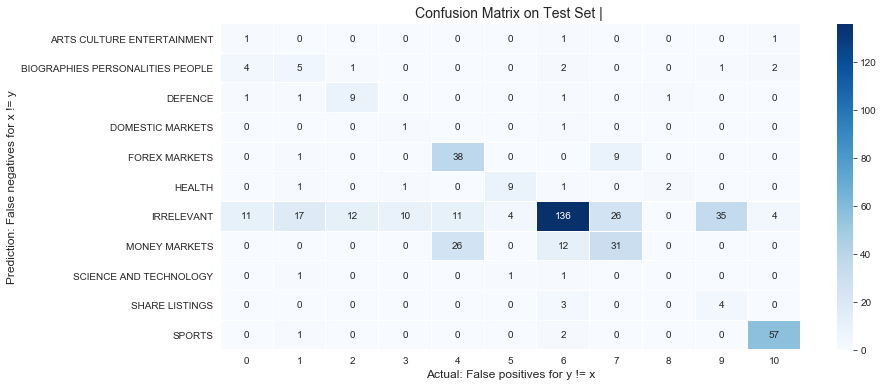

----------------------------------------------------------------------
Now, the train_df is df_train_10, the test_df is df_test_full
F1 score for  SVC  model is  0.40393690304232455
Accuracy score for  SVC  model is  0.582
Recall score for  SVC  model is  0.5250436634303911 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.06      0.33      0.10         3
           1       0.19      0.33      0.24        15
           2       0.41      0.69      0.51        13
           3       0.08      0.50      0.14         2
           4       0.51      0.79      0.62        48
           5       0.64      0.64      0.64        14
           6       0.85      0.51      0.64       266
           7       0.47

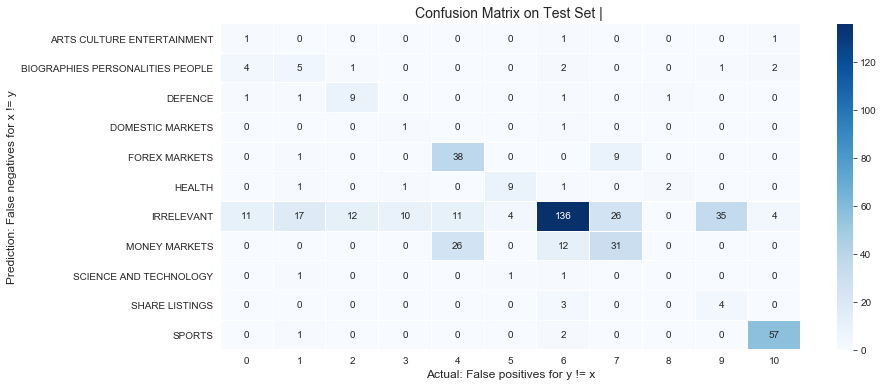

*************************************************************
Now the training set is df_train_20, and the model chosen is wc
The accuracy is 0.6628362237510259
----------------------------------------------------------------------
Now, the train_df is df_train_20, the test_df is df_test_20
F1 score for  SVC  model is  0.44880059752708984
Accuracy score for  SVC  model is  0.654
Recall score for  SVC  model is  0.5783696471339492 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.29      0.40      0.33        15
           2       0.50      0.77      0.61        13
           3       0.22      1.00      0.36         2
           4       0.51   

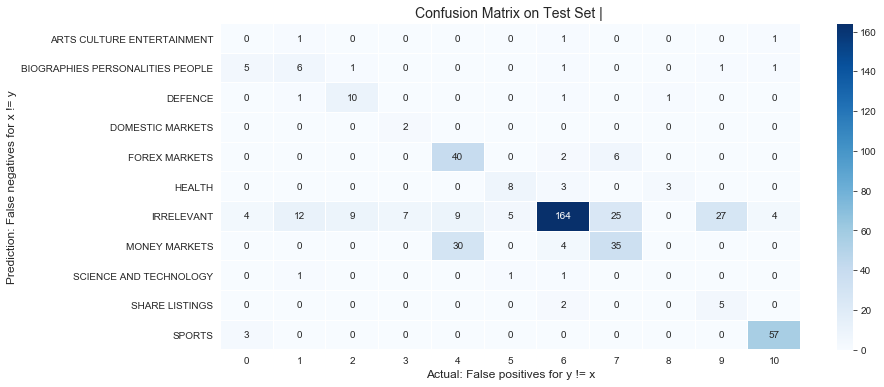

----------------------------------------------------------------------
Now, the train_df is df_train_20, the test_df is df_test_50
F1 score for  SVC  model is  0.44880059752708984
Accuracy score for  SVC  model is  0.654
Recall score for  SVC  model is  0.5783696471339492 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.29      0.40      0.33        15
           2       0.50      0.77      0.61        13
           3       0.22      1.00      0.36         2
           4       0.51      0.83      0.63        48
           5       0.57      0.57      0.57        14
           6       0.92      0.62      0.74       266
           7       0.53  

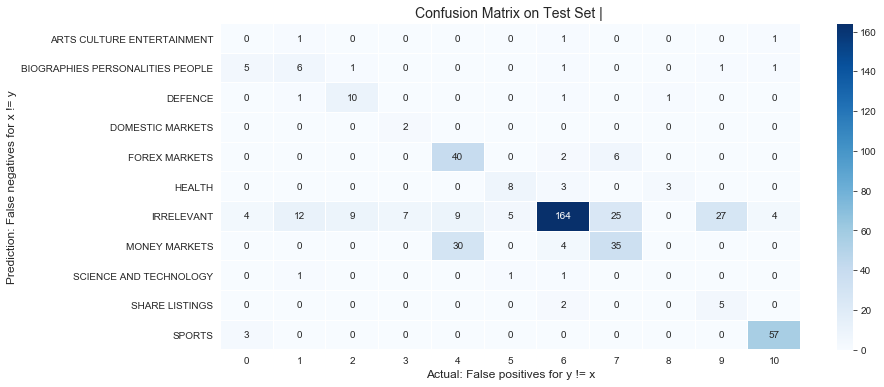

----------------------------------------------------------------------
Now, the train_df is df_train_20, the test_df is df_test_100
F1 score for  SVC  model is  0.44880059752708984
Accuracy score for  SVC  model is  0.654
Recall score for  SVC  model is  0.5783696471339492 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.29      0.40      0.33        15
           2       0.50      0.77      0.61        13
           3       0.22      1.00      0.36         2
           4       0.51      0.83      0.63        48
           5       0.57      0.57      0.57        14
           6       0.92      0.62      0.74       266
           7       0.53 

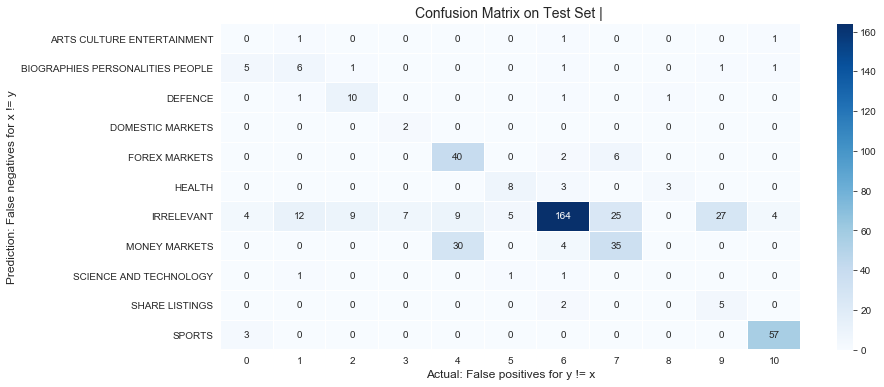

----------------------------------------------------------------------
Now, the train_df is df_train_20, the test_df is df_test_full
F1 score for  SVC  model is  0.44880059752708984
Accuracy score for  SVC  model is  0.654
Recall score for  SVC  model is  0.5783696471339492 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.29      0.40      0.33        15
           2       0.50      0.77      0.61        13
           3       0.22      1.00      0.36         2
           4       0.51      0.83      0.63        48
           5       0.57      0.57      0.57        14
           6       0.92      0.62      0.74       266
           7       0.53

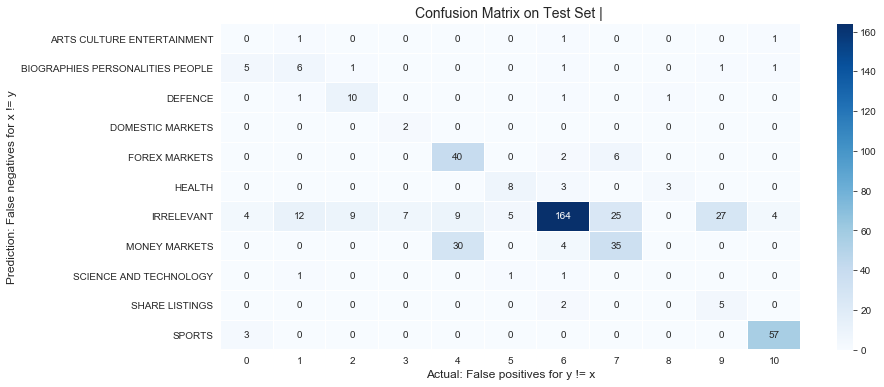

*************************************************************
Now the training set is df_train_50, and the model chosen is wc
The accuracy is 0.7216842105263158
----------------------------------------------------------------------
Now, the train_df is df_train_50, the test_df is df_test_20
F1 score for  SVC  model is  0.4809633745127458
Accuracy score for  SVC  model is  0.71
Recall score for  SVC  model is  0.5956860549823937 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.07      0.33      0.12         3
           1       0.33      0.27      0.30        15
           2       0.69      0.69      0.69        13
           3       0.22      1.00      0.36         2
           4       0.52     

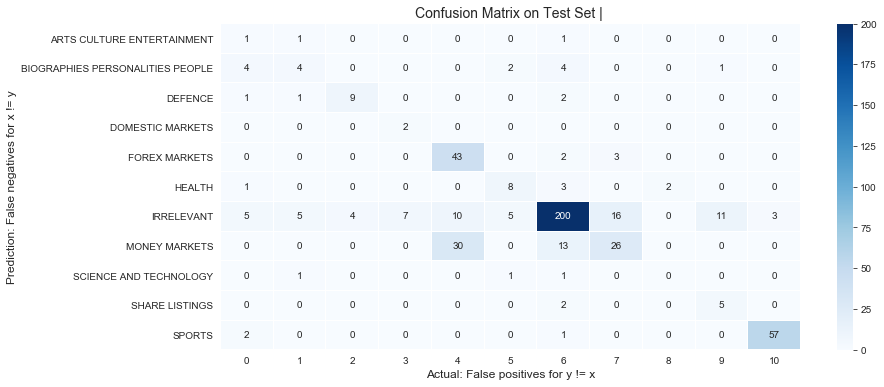

----------------------------------------------------------------------
Now, the train_df is df_train_50, the test_df is df_test_50
F1 score for  SVC  model is  0.5857787035471279
Accuracy score for  SVC  model is  0.75
Recall score for  SVC  model is  0.7387888141606677 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.25      0.67      0.36         3
           1       0.56      0.60      0.58        15
           2       0.67      0.92      0.77        13
           3       0.22      1.00      0.36         2
           4       0.54      0.85      0.66        48
           5       0.53      0.64      0.58        14
           6       0.93      0.74      0.83       266
           7       0.60    

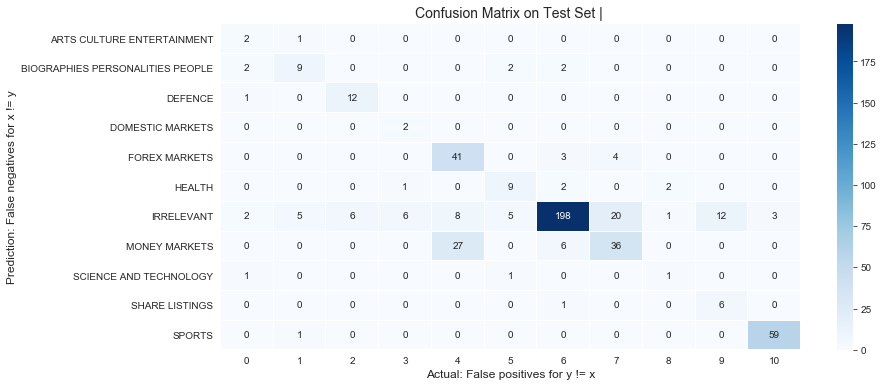

----------------------------------------------------------------------
Now, the train_df is df_train_50, the test_df is df_test_100
F1 score for  SVC  model is  0.5857787035471279
Accuracy score for  SVC  model is  0.75
Recall score for  SVC  model is  0.7387888141606677 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.25      0.67      0.36         3
           1       0.56      0.60      0.58        15
           2       0.67      0.92      0.77        13
           3       0.22      1.00      0.36         2
           4       0.54      0.85      0.66        48
           5       0.53      0.64      0.58        14
           6       0.93      0.74      0.83       266
           7       0.60   

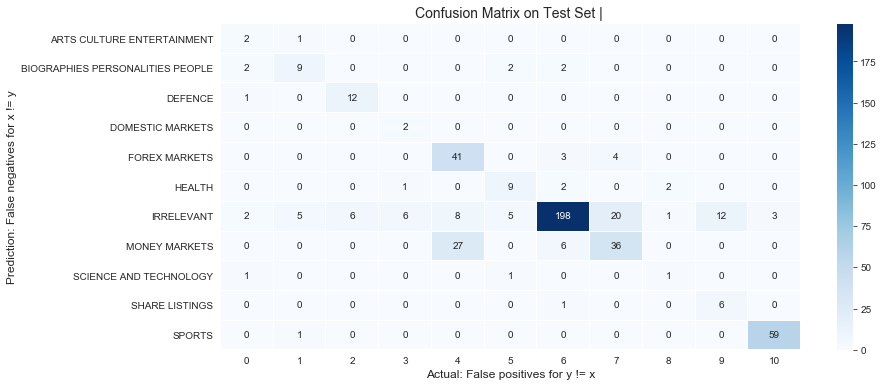

----------------------------------------------------------------------
Now, the train_df is df_train_50, the test_df is df_test_full
F1 score for  SVC  model is  0.5857787035471279
Accuracy score for  SVC  model is  0.75
Recall score for  SVC  model is  0.7387888141606677 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.25      0.67      0.36         3
           1       0.56      0.60      0.58        15
           2       0.67      0.92      0.77        13
           3       0.22      1.00      0.36         2
           4       0.54      0.85      0.66        48
           5       0.53      0.64      0.58        14
           6       0.93      0.74      0.83       266
           7       0.60  

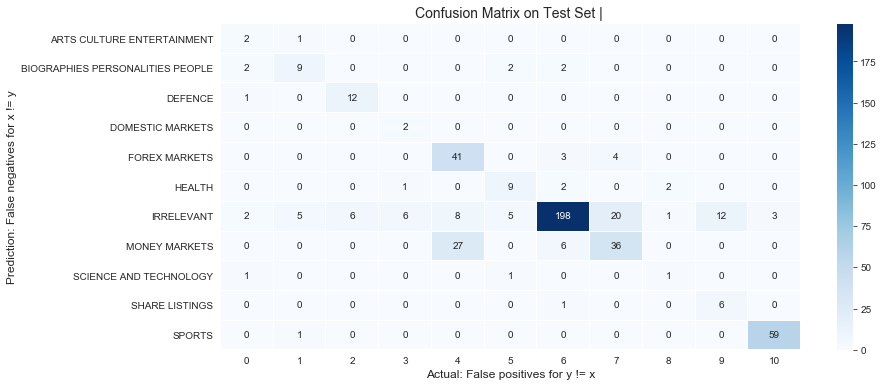

*************************************************************
Now the training set is df_train_100, and the model chosen is wc
The accuracy is 0.7466315789473684
----------------------------------------------------------------------
Now, the train_df is df_train_100, the test_df is df_test_20
F1 score for  SVC  model is  0.47218538503133983
Accuracy score for  SVC  model is  0.698
Recall score for  SVC  model is  0.578694093854277 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.20      0.33      0.25         3
           1       0.40      0.13      0.20        15
           2       0.75      0.69      0.72        13
           3       0.22      1.00      0.36         2
           4       0.48  

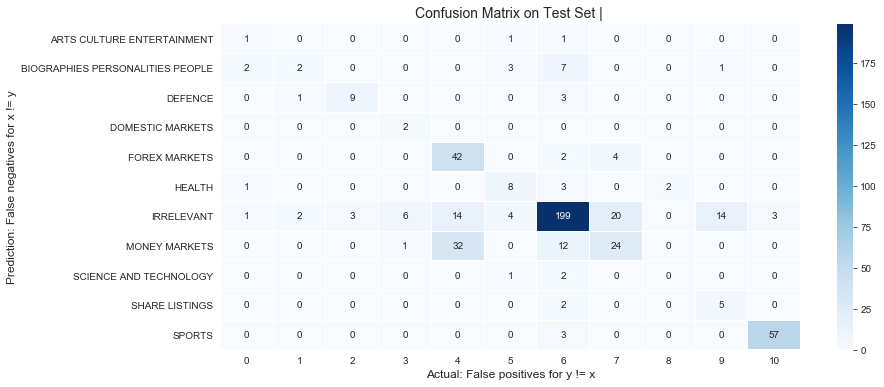

----------------------------------------------------------------------
Now, the train_df is df_train_100, the test_df is df_test_50
F1 score for  SVC  model is  0.5830511519663609
Accuracy score for  SVC  model is  0.738
Recall score for  SVC  model is  0.7296442878250656 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.33      0.67      0.44         3
           1       0.47      0.53      0.50        15
           2       0.80      0.92      0.86        13
           3       0.22      1.00      0.36         2
           4       0.54      0.88      0.67        48
           5       0.56      0.64      0.60        14
           6       0.93      0.73      0.82       266
           7       0.54  

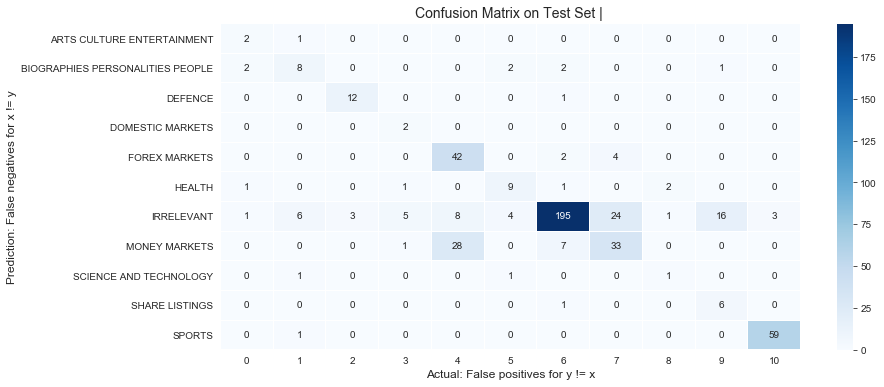

----------------------------------------------------------------------
Now, the train_df is df_train_100, the test_df is df_test_100
F1 score for  SVC  model is  0.625717214978584
Accuracy score for  SVC  model is  0.78
Recall score for  SVC  model is  0.7423347342969767 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.67      0.57         3
           1       0.58      0.47      0.52        15
           2       0.67      0.92      0.77        13
           3       0.22      1.00      0.36         2
           4       0.58      0.85      0.69        48
           5       0.59      0.71      0.65        14
           6       0.94      0.79      0.86       266
           7       0.60   

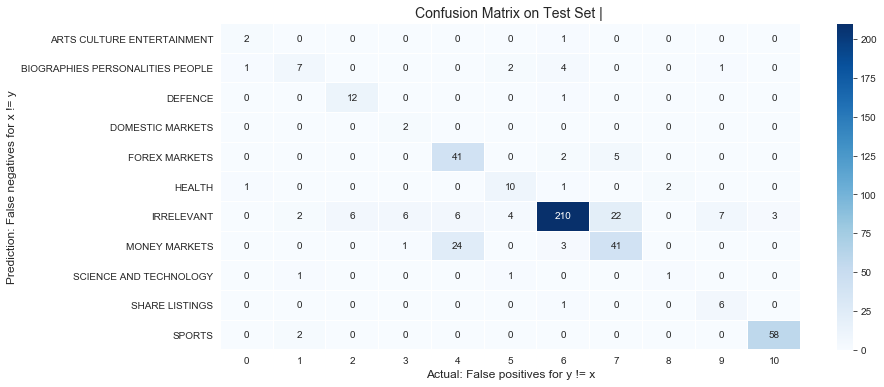

----------------------------------------------------------------------
Now, the train_df is df_train_100, the test_df is df_test_full
F1 score for  SVC  model is  0.625717214978584
Accuracy score for  SVC  model is  0.78
Recall score for  SVC  model is  0.7423347342969767 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.67      0.57         3
           1       0.58      0.47      0.52        15
           2       0.67      0.92      0.77        13
           3       0.22      1.00      0.36         2
           4       0.58      0.85      0.69        48
           5       0.59      0.71      0.65        14
           6       0.94      0.79      0.86       266
           7       0.60  

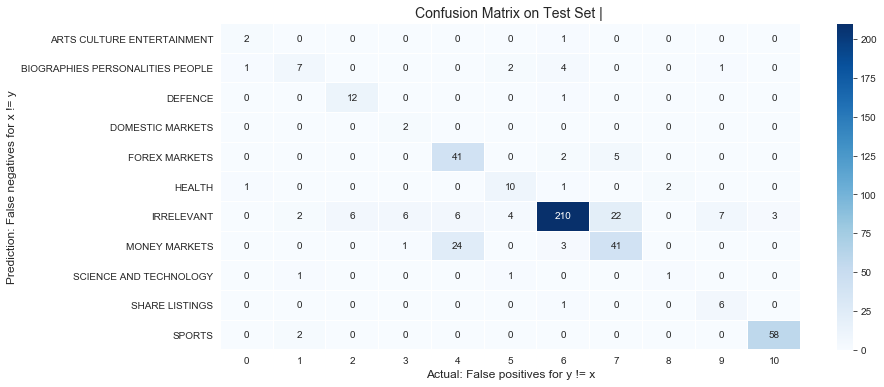

In [30]:
for train_df in df_train_all:
    svm_model,le,encode_mapping,the_vect = get_model_nosmote(train_df)
    for test_df in df_test_all:
        if (test_df.isnull().values.any()):
            continue
        print('----------------------------------------------------------------------')
        print(f'Now, the train_df is {train_df.name}, the test_df is {test_df.name}')
        test_model(test_df, svm_model,le,encode_mapping, the_vect)

NameError: name 'df_train' is not defined